In [1]:
import os
import numpy as np
import pandas as pd

# plot
import glob
# import cv2
import matplotlib.pyplot as plt

# tf
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import splitfolders

import pathlib

## Data Collecting

Dataset diambil dari website kaggle.

### Tujuan PA

Membuat sebuah model yang dapat mengenali jenis dari serangga dengan menggunakan algoritma CNN.

Batasan:
  - Model ini hanya dapat mengenali:
    - Kupu - Kupu, 
    - Capung, 
    - Nyamuk, 
    - Belalang,
    - dan Kumbang.

### Deskripsi Dataset

Dataset ini berupa gambar dari 5 serangga berbeda.

### Jumlah Dataset

- Kupu - Kupu: 899
- Capung: 1036
- Nyamuk: 690
- Belalang: 960
- Kumbang: 864

Total: 4449 data

### Data Train & Validation

URL path ke direktori dataset.
berupa direktori dataset.
dan dataset output (dataset yang akan dihasilkan ketika melakukan split folder). 

In [2]:
url = 'insect'
# url = 'dataset_serangga'
url_split = 'dataset_output'

In [3]:
splitfolders.ratio(url, output=url_split, seed=42, ratio=(0.7,0.2,0.1), group_prefix=None)

Disini saya menggunakan Image data generator dan batch size sebanyak 128
untuk validation, saya menggunakan 20% data.
Kemudian untuk subset training dan validation, target size nya adalah 120.

ambil path dari folder masing - masing output

In [4]:
train = 'dataset_output/train'
val = 'dataset_output/val'
test = 'dataset_output/test'

In [5]:
batch_size = 128

train_image_generator = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45,
    width_shift_range= 0.2,
    height_shift_range=0.2,
    zoom_range= 0.2,
    horizontal_flip=True,
    validation_split= 0.1,
    fill_mode='nearest',
) #data preprocessing

train = train_image_generator.flow_from_directory(
    train, 
    target_size=(150,150),
    batch_size=batch_size, 
    color_mode="grayscale"
)

test = train_image_generator.flow_from_directory(
    test, 
    target_size=(150,150),
    batch_size=batch_size,
    color_mode="grayscale"
)

val = train_image_generator.flow_from_directory(
    val, 
    target_size=(150,150),
    batch_size=batch_size,
    color_mode="grayscale"
)

Found 3112 images belonging to 5 classes.
Found 449 images belonging to 5 classes.
Found 888 images belonging to 5 classes.


### Visualisasi Dataset

In [6]:
class_names = os.listdir('dataset_output/train/')
class_names

['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito']

**Preview Dataset**

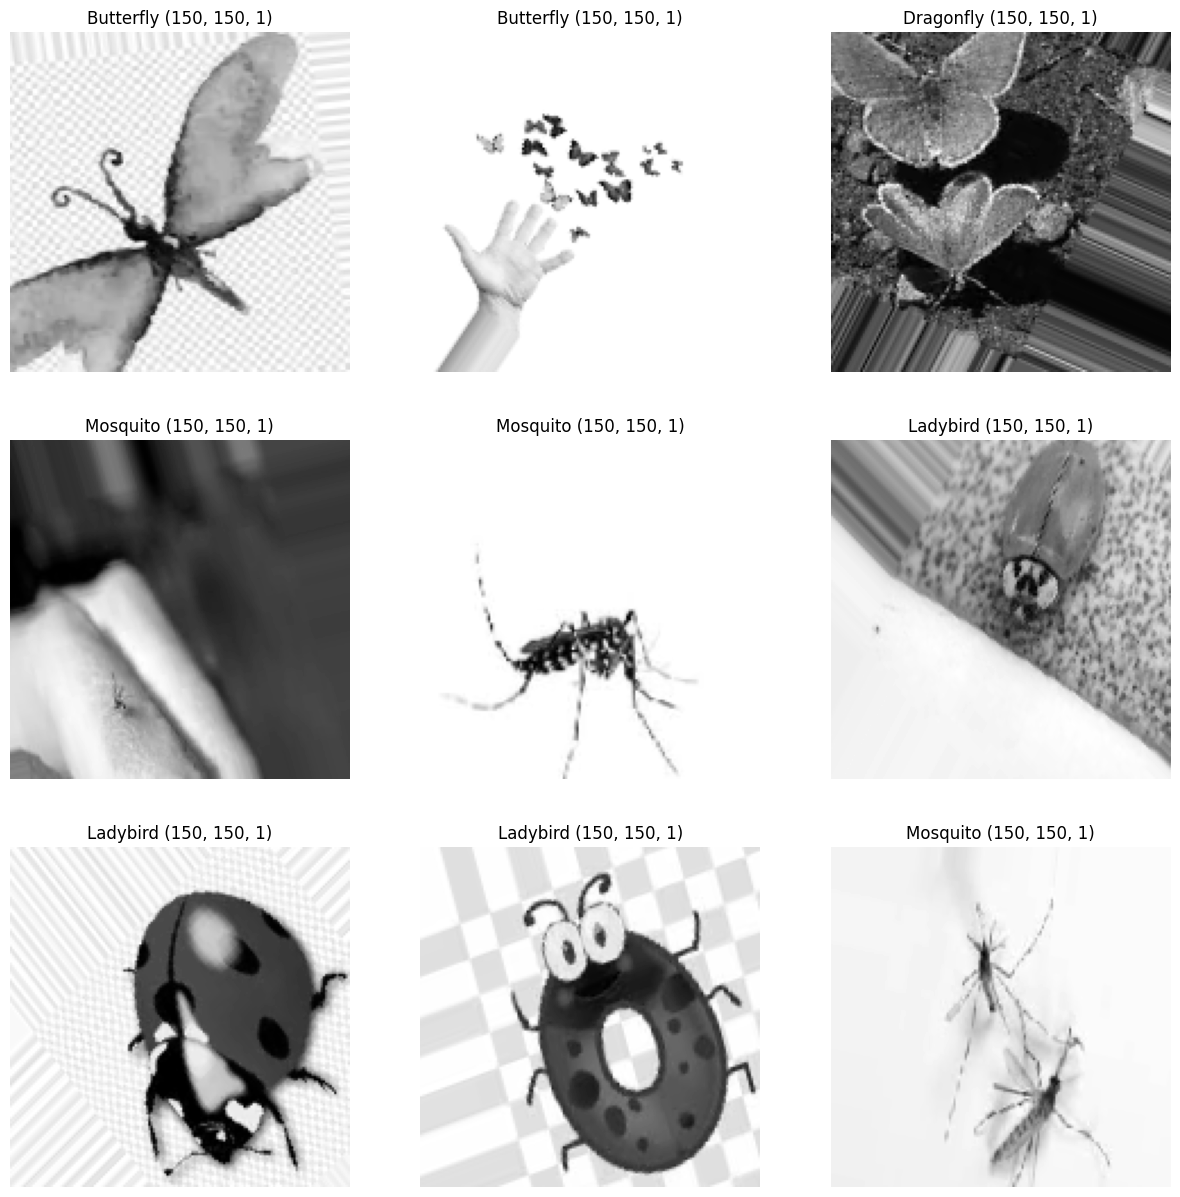

In [7]:
img,label = train.next() 
# Buat folder dlu disesuaikan sama nama di save_to_dir
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[i],cmap='gray')
    plt.title(f'{class_names[tf.argmax(label[i])]} {img[i].shape}')
    plt.axis('off')


**Metadata**

In [8]:
# folder
path = 'insect/'

# lokasi train
path_train = 'dataset_output/train'

# lokasi test
path_test = 'dataset_output/test'

# lokasi validation
path_val = 'dataset_output/val'

def getSize():
    count = 0
    data_dir = pathlib.Path(path)
    count += len(list(data_dir.glob('*/*.jpg')))
    return count


def getSizeTrain():
    count = 0
    data_dir = pathlib.Path(path_train)
    count += len(list(data_dir.glob('*/*.jpg')))
    return count

def getSizeTest():
    count = 0
    data_dir = pathlib.Path(path_test)
    count += len(list(data_dir.glob('*/*.jpg')))
    return count

def getSizeVal():
    count = 0
    data_dir = pathlib.Path(path_val)
    count += len(list(data_dir.glob('*/*.jpg')))
    return count



In [9]:
print("Nama Dataset      : Insect")
print("URL               : https://www.kaggle.com/search?q=insect+dataset" )
print("Image shape       :", img[0].shape)
print("Jumlah Data       :", getSize())
print("Jumlah Data Train :", getSizeTrain())
print("Jumlah Data Test  :", getSizeTest())
print("Jumlah Data val   :", getSizeVal())
print("Seluruh class     :", class_names)

Nama Dataset      : Insect
URL               : https://www.kaggle.com/search?q=insect+dataset
Image shape       : (150, 150, 1)
Jumlah Data       : 4449
Jumlah Data Train : 3112
Jumlah Data Test  : 449
Jumlah Data val   : 888
Seluruh class     : ['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito']


**Class Distribution**

In [10]:
class_size = []

for i in os.listdir(path_train):
    image_count = 0
    data_dir = pathlib.Path(path_train + '/' +i)
    image_count = len(os.listdir(data_dir))
    class_size.append(image_count)

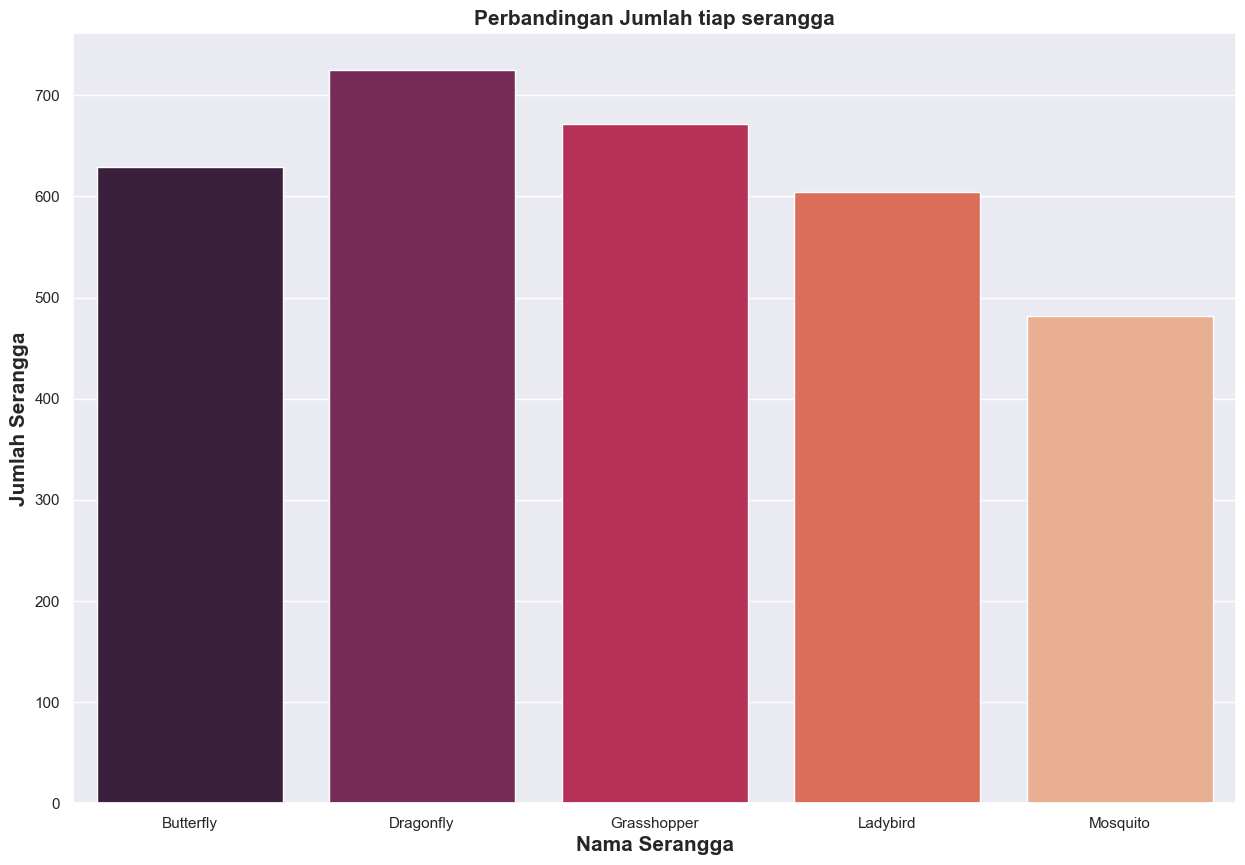

In [11]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(15,10))

sns.barplot(x=class_names,y=class_size,palette='rocket')
plt.title("Perbandingan Jumlah tiap serangga",fontfamily='arial',fontsize=15, fontweight='bold')
plt.xlabel('Nama Serangga',fontfamily='arial',fontsize=15, fontweight='bold')
plt.ylabel('Jumlah Serangga',fontfamily='arial',fontsize=15, fontweight='bold')
plt.show()

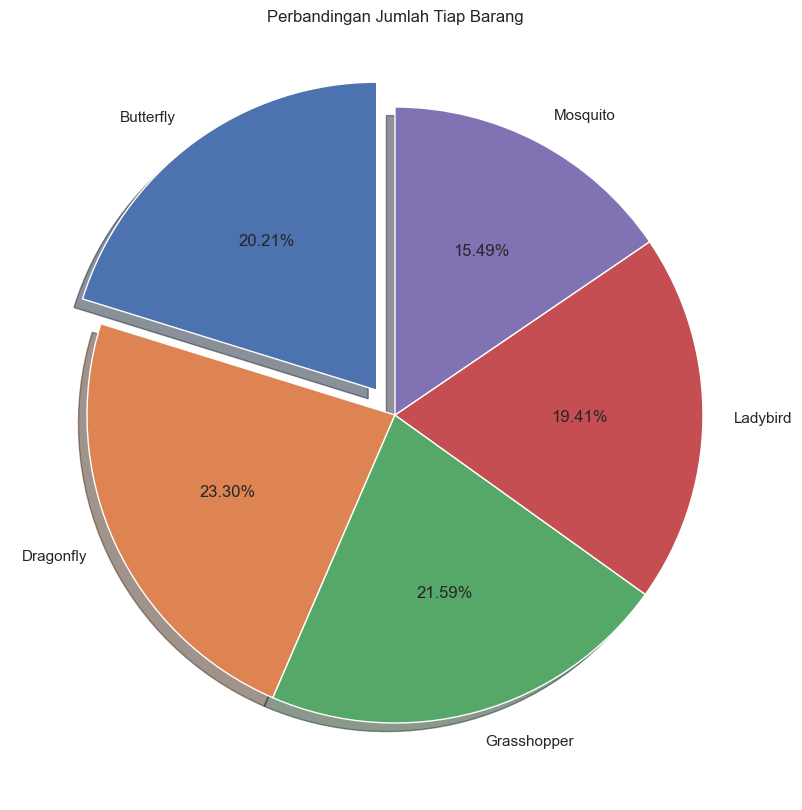

In [12]:
plt.figure(figsize=(10,10))
plt.pie(class_size, labels=class_names,startangle=90,autopct='%.2f%%',shadow=True,explode=(0.10,0,0,0,0))
plt.title('Perbandingan Jumlah Tiap Barang')
plt.show()

In [13]:
# rows = 2
# cols = 3
# # fig = plt.figure(figsize=(7,8))
# # for j in range (0, rows*cols):
# #     fig.add_subplot(rows, cols, j+1)
# #     plt.imshow(img[j])

# for i in range(0, len(img), rows*cols):
#     fig = plt.figure(figsize=(7,8))
#     for j in range (0, rows*cols):
#         fig.add_subplot(rows, cols, j+1)
#         plt.imshow(img[j])
#         # plt.imshow(img[i+j])
#     plt.show()

In [14]:
# plt.title(label_name[tf.argmax(label[2])])
# plt.imshow(image[2])
# plt.show()

# Model 

Pada syntax di atas model dibentuk dengan suatu layer convo 2 dimensi dari size 120 x 120 pixels dimana fungsi aktivasinya adalah. Terdapat dua pembuatan layer convo, sehingga dilanjutkan dengan pembuatan layer max pooling dan pembuatan layer dropout. Karena ini adalah pelatihan deep learning maka perlu pelatihan lagi dengan membuat lagi layer untuk pelatihan. Kemudian dilanjutkan dengan layer flatten dan layer dense sampai dengan proses kompilasi.



In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
        
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3), # drop neuron secara random

    tf.keras.layers.Flatten(), # untuk jadikan 1dimensi

    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1024, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax'), #multiclass pakai softmax
])

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# adam untuk mengurangi overfitting


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 256)      0

In [17]:
monitor_loss_callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [18]:
# coba pakai callback custom misalnya: stop kalau accuracy train > 95%, dan earlystopping
# history = model.fit(train, validation_data=val, epochs=50)
history = model.fit(train, validation_data=val, epochs=100, callbacks=monitor_loss_callbacks)

Epoch 1/100
25/25 [==============================] - 278s 11s/step - loss: 1.6079 - accuracy: 0.2294 - val_loss: 1.6007 - val_accuracy: 0.2331
Epoch 2/100
25/25 [==============================] - 272s 11s/step - loss: 1.6002 - accuracy: 0.2317 - val_loss: 1.5929 - val_accuracy: 0.2590
Epoch 3/100
 9/25 [=========>....................] - ETA: 1:21:47 - loss: 1.5905 - accuracy: 0.2331

In [ ]:
loss_per_epoch = history.history["loss"]
n_epoch = list(range(len(loss_per_epoch)))

plt.figure(figsize=(30, 8))
sns.lineplot(data=loss_per_epoch, linewidth=2.5, marker="o", linestyle='solid').set(xlabel='n_epoch', ylabel='loss', title='LOSS', xticks=n_epoch)
plt.show()

## Evaluasi

In [ ]:
model.evaluate(test)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Training')
plt.plot(epochs, val_acc, 'g', label='Akurasi Validation')

plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.title('Akurasi Training and validation')
plt.grid(axis='both')

plt.show() 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(1, figsize=(4,4))
plt.plot(epochs,  acc, c='r', label='training')
plt.plot(epochs,  val_acc, c='r', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('akurasi')

plt.figure(1, figsize=(4,4))
plt.plot(epochs,  loss, c='r', label='training')
plt.plot(epochs,  epochs, c='r', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('akurasi')

plt.show()

# plt.plot(epochs, acc, 'r', label='Akurasi Training')
# plt.plot(epochs, val_acc, 'g', label='Akurasi Validation')

# plt.xlabel('Epochs')
# plt.ylabel('Akurasi')
# plt.title('Akurasi Training and validation')
# plt.grid(axis='both')

# plt.show() 